# Рекомендация тарифов

## Выгрузка данных и изучение общей информации

### Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv(r'C:\Users\HuaweiMatebook\jupyternotebooks\users_behavior.csv')

### Первичный осмотр данных

Первые 10 строк датафрейма:

In [3]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Общая информация о датафрейме:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Количественное описание данных датафрейма:

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


Итак, в таблице 5 столбцов и 3214 строк. В данных нет пропущенных значений. Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

В нашей задаче целевым признаком является столбец `is_ultra`. Целевой признак - категориальный, значит решается задача классификации, а именно, бинарной классификации.

In [6]:
# Проверим датасет на сбалансированность классов в целевом признаке. Посчитаем количество экземпляров каждого класса
class_counts = df['is_ultra'].value_counts()
class_counts

is_ultra
0    2229
1     985
Name: count, dtype: int64

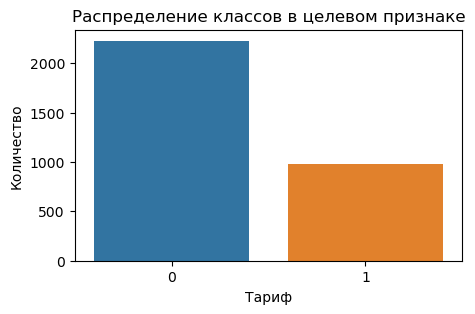

In [7]:
# Отобразим распределение классов на графике, чтобы визуально оценить сбалансированность
plt.figure(figsize=(5, 3))
sns.barplot(data=df, x=class_counts.index, y=class_counts.values)
plt.xlabel('Тариф')
plt.ylabel('Количество')
plt.title('Распределение классов в целевом признаке')
plt.xticks([0, 1])
plt.show()

Получился несбалансированный датасет, так как количество экземпляров класса 0 значительно больше, чем количество экземпляров класса 1.

**Корреляция признаков**

In [8]:
# Посмотрим на матрицу корреляции признаков
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


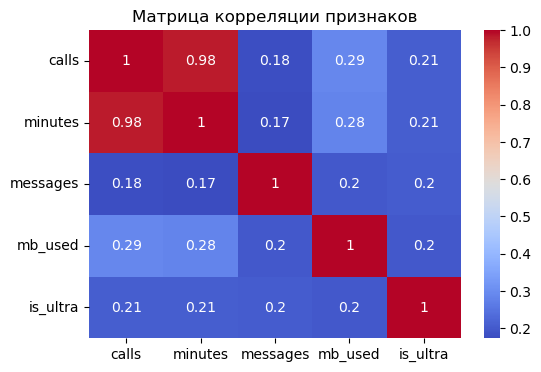

In [9]:
# Построим тепловую карту, чтобы визуально оценить силу и направление корреляции между признаками.
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляции признаков')
plt.show()

Количество звонков `calls` и суммарная длительность звонков `minutes` имеют очень высокую корреляцию, что логично, так как длительность звонков напрямую связана с их количеством. Остальные признаки имеют некоторую корреляцию, но она не очень высокая.

В целом, матрица корреляции показывает, что признаки не сильно коррелируют между собой (кроме `calls` и `minutes`) и с целевым признаком. Это хорошо для построения модели, так как сильной мультиколлинеарности не будет.

## Разделение данных на выборки

In [10]:
# Для равномерного распределения количества классов в наборе данных определим переменные с признаками и целевым признаком
X = df.drop('is_ultra', axis=1)
y = df['is_ultra']

Для начала исходные данные разделим на две выборки: обучающую и временную. При этом распределение классов сохраняется во всех выборках.

In [11]:
features_train, features_temp, target_train, target_temp = train_test_split(X, y, test_size=0.4, random_state=12345, 
                                                                            stratify=y)

Теперь временную выборку разделим поровну на валидационную и тестовую.

In [12]:
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5,
                                                                            random_state=12345, stratify=target_temp)

Выведем размеры получившихся выборок:

In [13]:
print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (1928, 4)
Размер валидационной выборки: (643, 4)
Размер тестовой выборки: (643, 4)


Таким образом, мы разбили исходные данные в соотношении 3:1:1 на обучающую, валидационную и тестовую выборки. 

## Исследование моделей

Проверим 3 модели:
- Решающее дерево
- Случайный лес
- Логистическая регрессия

Качество работы будем оценивать метрикой качества - `accuracy`.

### Решающее дерево

Самый важный гиперпараметр решающего дерева — `max_depth`.

В цикле будем перебирать разные значения `max_depth` и сравнивать качество моделей в разных вариантах.

In [14]:
best_result_df = 0
# Создадим списки, где будет сохраняться качество моделей при разных max_depth для построения графика
accuracy_valid = []
accuracy_train = []
max_depth_list = list(range(1, 26))

for depth in max_depth_list:
    model_df = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_df.fit(features_train, target_train)
    predictions_valid = model_df.predict(features_valid) # предсказаниеи модели на валидационной выборке
    predictions_train = model_df.predict(features_train) # предсказание модели на обучающей выборке
    result_valid = accuracy_score(target_valid, predictions_valid)
    result_train = accuracy_score(target_train, predictions_train)
    accuracy_valid.append(result_valid)
    accuracy_train.append(result_train)    
    if result_valid > best_result_df:
        best_model_df = model_df
        best_result_df = result_valid
        best_depth_df = depth

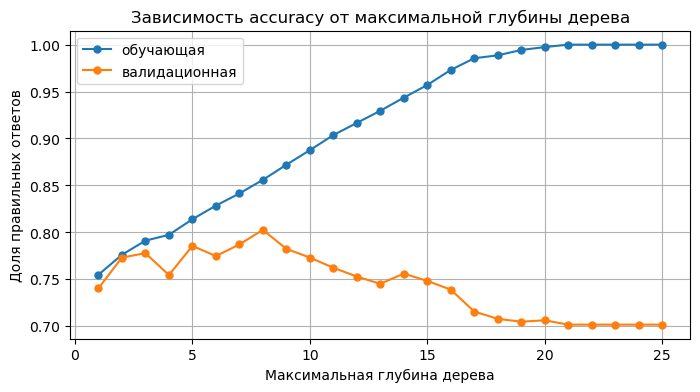

In [15]:
# Построим график влияния max_depth на accuracy
plt.figure(figsize=(8,4))
plt.plot(max_depth_list, accuracy_train, label='обучающая', marker='o', ms=5)
plt.plot(max_depth_list, accuracy_valid, label='валидационная', marker='o', ms=5)
plt.legend()
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Доля правильных ответов')
plt.title('Зависимость accuracy от максимальной глубины дерева')
plt.grid(True)
plt.show()

Выведем результаты расчета с лучшим показателем `accuracy`:

In [16]:
print('Максимальная глубина:', best_depth_df)
print('Доля правильных ответов:', round(best_result_df, 2))

Максимальная глубина: 8
Доля правильных ответов: 0.8


При увеличении значения `max_depth` до определенного уровня, `accuracy` как на обучающей, так и на валидационной выборке увеличивается, что указывает на улучшение производительности модели. Оптимальная глубина дерева, при которой достигается наилучшая `accuracy` на валидационной выборке составляет 8. После достижения оптимального значения `max_depth`, увеличение этого гиперпараметра приводит к переобучению модели.

### Случайный лес

Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования.

Чтобы управлять количеством деревьев, прописывают гиперпараметр - `n_estimators`.

Для лучшего качества будем в цикле перебирать разные значения `max_depth` и `n_estimators`.

In [17]:
best_result_rf = 0

for n_est in tqdm(range(10, 51, 10)):
    for depth in range(1, 11):
        model_rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=12345)
        model_rf.fit(features_train, target_train)
        predictions_valid = model_rf.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result
            best_depth_rf = depth
            best_n_est_rf = n_est

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.36s/it]


Выведем результаты расчета с лучшим показателем `accuracy`:

In [18]:
print('Количество деревьев:', best_n_est_rf)
print('Максимальная глубина:', best_depth_rf)
print('Доля правильных ответов:', round(best_result_rf, 2))

Количество деревьев: 40
Максимальная глубина: 9
Доля правильных ответов: 0.82


### Логистическая регрессия

Для решения задачи классификации также широко используется логистическая регрессия. Для настройки модели будем задавать следующие гиперпараметры:
* `solver` - позволяет выбрать алгоритм, который будет строить модель. Алгоритм `lbfgs` — один из самых распространённых.
* `max_iter` - этот гиперпараметр задаёт максимальное количество итераций обучения. Значение этого параметра по умолчанию равно 100.

In [19]:
model_lr = LogisticRegression(solver='lbfgs', max_iter=100, random_state=12345)
model_lr.fit(features_train, target_train)
predictions_valid = model_lr.predict(features_valid)
result_lr = accuracy_score(target_valid, predictions_valid)  

Выведем результат расчета:

In [20]:
print('Доля правильных ответов:', round(result_lr,2))

Доля правильных ответов: 0.74


**Вывод**

* Самое высокое качество у случайного леса: `accuracy` = 0.82.
* На втором месте - дерево решений с `accuracy` = 0.80.
* Самое низкое качество предсказания у логистической регрессии с `accuracy` = 0.74.

Таким образом, далее будем работать с моделью случайного леса, которая показала наилучший результат по качеству работы.

## Проверка модели на тестовой выборке

In [21]:
# Проверим модель на тестовой выборке
predictions_test = best_model_rf.predict(features_test)

In [22]:
# Посчитаем долю правильных ответов
round(accuracy_score(target_test, predictions_test), 2)

0.81

При проверке модели на тестовой выборке мы получили долю правильных ответов равную 0.81, что говорит о том, что модель хорошо справляется с задачей классификации клиентов на тарифы "Смарт" и "Ультра" на основе их поведения.

**Расчет других метрик качества**

In [23]:
print('precision:', round(precision_score(target_test, predictions_test), 2))
print('recall:', round(recall_score(target_test, predictions_test), 2))
print('F1-score:', round(f1_score(target_test, predictions_test), 2))

precision: 0.76
recall: 0.54
F1-score: 0.64


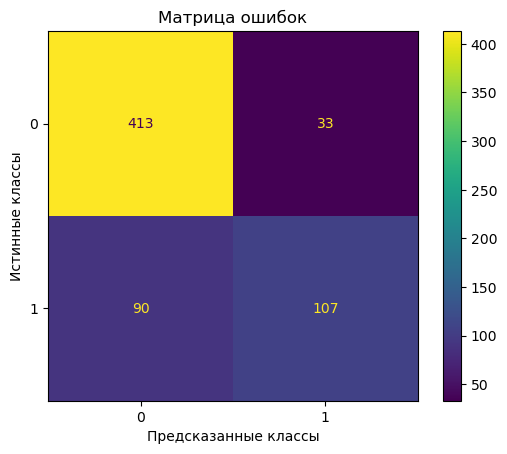

In [24]:
# Отдельно покажем матрицу ошибок
cm = confusion_matrix(target_test, predictions_test)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_df.classes_)
cm_disp.plot()
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()

## Проверка модели на адекватность

Чтобы проверить модель на адекватность, сравним её с простой моделью (Dummy Models).

In [25]:
# Проверим модель, которая предсказывает класс, который встречается наиболее часто в обучающих данных
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train) # обучаем модель на обучающей выборке
predictions_dummy = dummy_model.predict(features_valid) # предсказываем на валидационной выборке
print('Accuracy dummy-модели:', round(accuracy_score(target_valid, predictions_dummy), 2))

Accuracy dummy-модели: 0.69


Наша модель случайного леса имеет `accuracy` выше этой цифры, что свидетельствует о том, что она лучше справляется с задачей классификации.

## Вывод

В рамках работы построена модель для задачи классификации, которая выберет подходящий тариф.

* Данные разделили на обучающую, валидационную, тестовую выборки. В данных наблюдается несбалансированное распределение классов.
* Исследованы три различные модели машинного обучения - Решающее дерево, Случайный лес и Логистическая регрессия. Для каждой модели подбирали оптимальные гиперпараметры и оценивали их производительность на валидационной выборке. 
    - Самое высокое качество у случайного леса: `accuracy` = 0.82.
    - На втором месте - дерево решений с `accuracy` = 0.80.
    - Самое низкое качество предсказания у логистической регрессии с `accuracy` = 0.74.
* На основе оценки качества моделей с использованием метрики `accuracy`, мы выбрали Случайный лес как модель с наилучшим показателем на валидационной выборке.
* Модель Случайного леса на тестовой выборке показал `accuracy` = 0.81. Это свидетельствует, что модель хорошо справляется с задачей классификации клиентов на тарифы "Смарт" и "Ультра" на основе их поведения.
* Модель прошла проверку на адекватность.
